# toy MC studies

The intention here is to assess any bias on the fit procedure and assess the variance on that bias.  This also includes a preliminary version of the systematics.  Further studies are done in w_br_asimov.ipynb.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/wbr/analysis


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'data/templates/bjet_binned/'
selections = ['mumu', 'mutau', 'mu4j', 'emu', 'ee', 'etau', 'e4j']
#selections = ['mumu', 'mutau', 'emu']
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'lepton2_pt', #'dilepton1_pt_asym', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu + h$'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e + h$']
                  )
n_selection = len(selections)

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets, bins=[0, 1])

In [3]:
# generate scan values
n_samples = 100
scan_type = 'random'

if scan_type == 'random':
    sv = (2*np.random.rand(3, n_samples) + 10)/100
    sv = sv.transpose()
    beta_h = 1 - np.sum(sv, axis=1)
    scan_vals = np.vstack((sv.transpose(), beta_h)).transpose()
elif scan_type == 'grid':
    n_samples = 1000
    beta_scan_vals = ScanParameters(['beta_e', 'beta_mu', 'beta_tau'], 
                                    [(0.10, 0.12), (0.10, 0.12), (0.10, 0.12)], 
                                    [10, 10, 10]
                                    )
    sv = np.array(beta_scan_vals.get_scan_vals()[0])
    beta_h = np.transpose([1 - np.sum(sv, axis=1)])
    scan_vals = np.hstack((sv, beta_h))

elif scan_type == 'fixed':
    scan_vals = np.array(n_samples*[[0.108, 0.108, 0.108, 1 - 3*0.108],])

In [4]:
# generate toy MC samples and produce some validation plots

samples = []
for sv in scan_vals:
    sample_dict = dict()
    for selection in selections:

        sample_dict[selection] = list()
        for b in fit_data._bins:
            # signal component
            templates = fit_data.get_selection_data(selection)
            signal_template = templates['signal'][b]
            toy_data = fh.signal_mixture_model(sv, br_tau, signal_template, sample=True)[0]

            # background component
            for bg in ['zjets', 'wjets', 'fakes']:
                if bg == 'fakes' and selection != 'mu4j':
                    continue

                bg_template = templates[bg][b][0]
                toy_data += np.random.poisson(bg_template)

            # mixture
            sample_dict[selection].append(toy_data)
    samples.append(sample_dict)

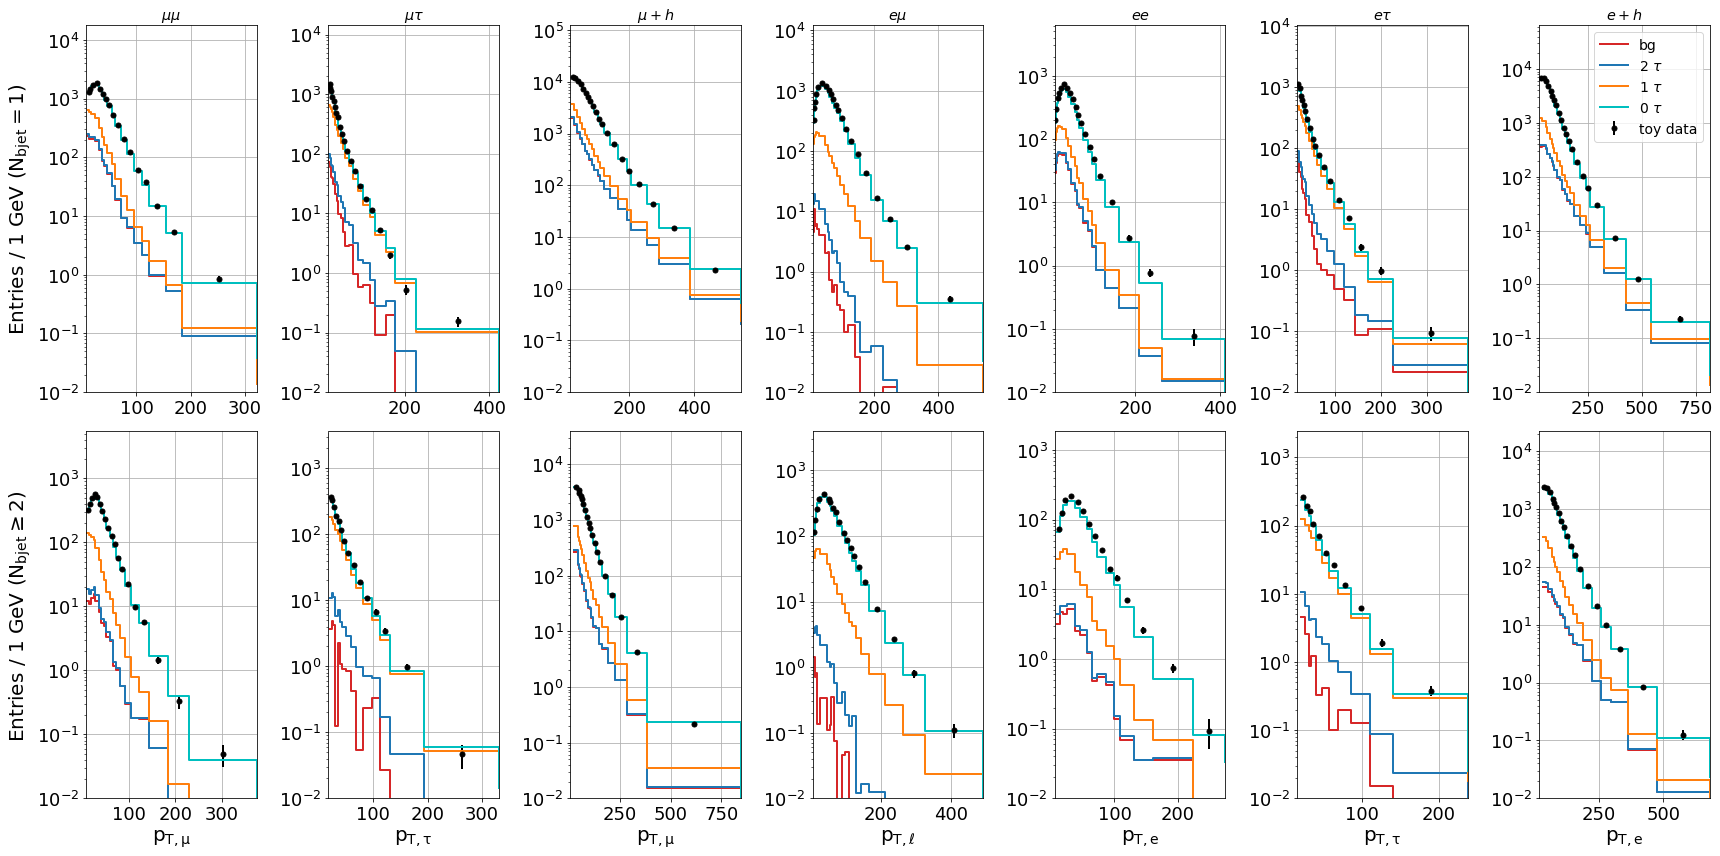

In [5]:
# visualize toy data
fig, axes = plt.subplots(2, 7, figsize=(24, 12), facecolor='white')
sample = samples[0]
for i, selection in enumerate(selections):
    s_data = fit_data.get_selection_data(selection)
#
    for b in fit_data._bins:
        bins = s_data['bins'][b]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x = bins + dx/2            

        ax = axes[b][i]
        data = sample[selection][b]
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        # validation plot
        br = 0.108
        signal = s_data['signal'][b]
        bg = s_data['wjets'][b][0] + s_data['zjets'][b][0]
        if selection == 'mu4j':
            bg += s_data['fakes'][b][0]
            
        h_notau   = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_twotau']) + bg
        h_onetau  = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_onetau']) + h_notau
        h_nominal = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal) + bg
        
        ax.plot(bins, bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2.)
        ax.plot(bins, h_notau[0]/dx, drawstyle='steps-post', c='C0', linestyle='-', linewidth=2.)
        ax.plot(bins, h_onetau[0]/dx, drawstyle='steps-post', c='C1', linestyle='-', linewidth=2.)
        ax.plot(bins, h_nominal[0]/dx, drawstyle='steps-post', c='c', linestyle='-', linewidth=2.)
        
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        if b == 0:
            ax.set_title(plot_labels[selection][1])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} = 1$)')
        elif b == 1:
            ax.set_xlabel(plot_labels[selection][0])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} \geq 2$)')
        ax.grid()
    
    axes[0][-1].legend(['bg', r'2 $\tau$', r'1 $\tau$', r'0 $\tau$', 'toy data'], fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example.pdf')
plt.show()

In [6]:
# Carry out the fits
p_init = list(fit_data.get_params_init()) + 5*[1., ] # niceify this: there is an additional paramter initialized to 1. for each nuisance parameter
bnds   = 3*[(0.09, 0.13), ] + [(0.6, 0.7)] + 5*[(0.5, 1.5), ]

results = []
dchi2 = []
cov = []
for i, sample in enumerate(tqdm_notebook(samples)):
    p_init[:4] = scan_vals[i]
    result = minimize(fit_data.objective, p_init,
                      method      = 'TNC',
                      bounds      = bnds,
                      args        = (sample, 'poisson')
                     ) 
    
    results.append(result.x)
    dchi2.append(fit_data.objective(p_init, sample) - result.fun)
    fobj = partial(fit_data.objective, data=sample, cost_type='poisson')
    cov.append(fh.calculate_covariance(fobj, result.x))
    
results = np.array(results)
dchi2 = np.array(dchi2)

HBox(children=(IntProgress(value=0), HTML(value='')))

/home/naodell/work/wbr/analysis/scripts/fit_helpers.py:157: RuntimeWarning: invalid value encountered in true_divide
  nll = (f_data - lumi*f_model)**2 / (var_data + var_model)


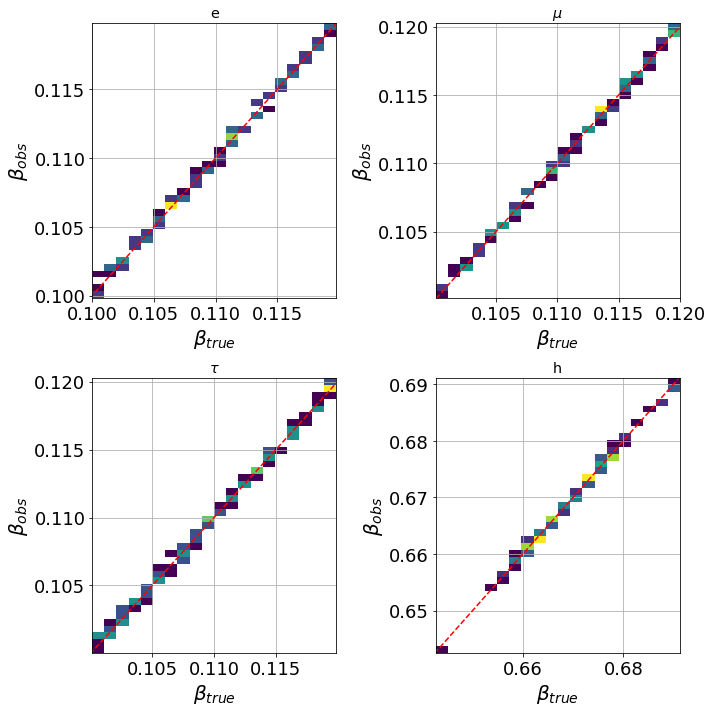

In [7]:
# visualize the scan
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white')

labels = ['e', r'$\mu$', r'$\tau$', 'h']
for i, b in enumerate(labels):
    ix, iy = int(i/2), int(i%2)
    ax = axes[ix][iy]
    ax.hist2d(scan_vals[:,i], results[:,i], bins=(20, 40), cmin=1.)
    ax.plot([0., 1.], [0., 1.], linestyle='--', c='r')
    
    #if b == 'h':
    #    ax.set_ylim(0.66, 0.69)
    #    ax.set_xlim(0.66, 0.69)
    #else:
    #    ax.set_ylim(0.102, 0.114)
    #    ax.set_xlim(0.102, 0.114)
        
    ax.grid()
    ax.set_title(b)
    ax.set_ylabel(r'$\beta_{obs}$')
    ax.set_xlabel(r'$\beta_{true}$')

plt.tight_layout()
plt.savefig(f'plots/systematics/beta_scan_{n_samples}.pdf')
plt.show()

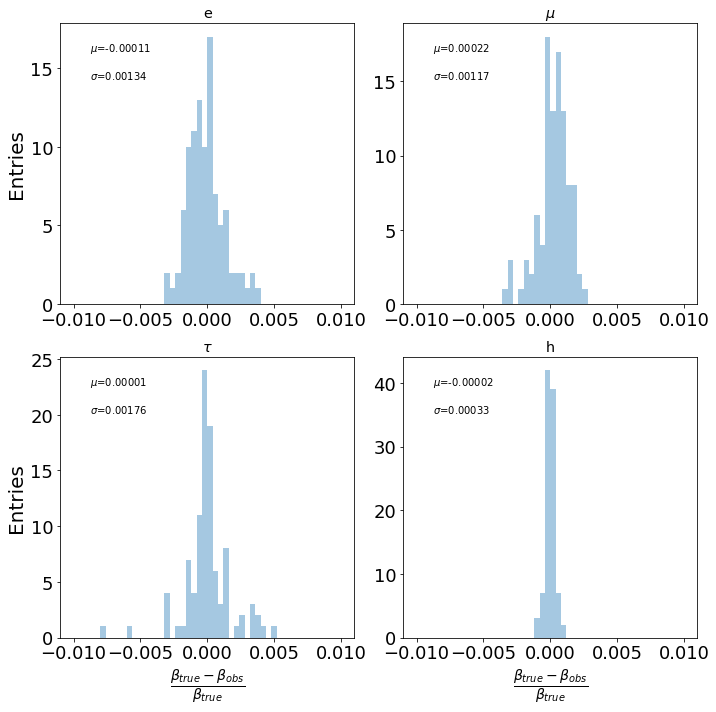

In [8]:
# biases
sig_bias = (results[:,:4] - scan_vals)/scan_vals
nuisance_bias = (results[:,4:] - p_init[4:])/p_init[4:]
bias = np.hstack((sig_bias, nuisance_bias))

fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white')#, sharex=True, sharey=True)
labels = ['e', r'$\mu$', r'$\tau$', 'h']
for i, b in enumerate(bias.transpose()[:4]):
    ix, iy = int(i/2), int(i%2)
    ax = axes[ix][iy]
    mean, stderr = b.mean(), b.std()
    ax.hist(b, bins=50, range=(-0.01, 0.01), histtype='stepfilled', alpha=0.4)
    ax.text(0.1, 0.9,r'$\mu$={0:.5f}'.format(mean), transform=ax.transAxes)
    ax.text(0.1, 0.8,r'$\sigma$={0:.5f}'.format(stderr), transform=ax.transAxes)
    
    ax.set_title(labels[i])
    if iy == 0:
        ax.set_ylabel(r'Entries')
    
    if ix == 1:
        ax.set_xlabel(r'$\frac{\beta_{true} - \beta_{obs}}{\beta_{true}}$')

plt.tight_layout()
plt.savefig(f'plots/systematics/parameter_bias_{n_samples}.pdf')
plt.show()

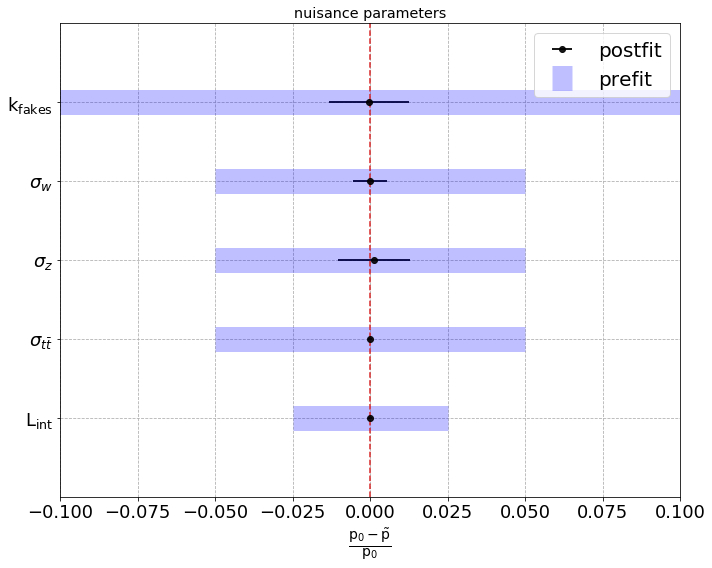

In [10]:
# biases
fig = plt.figure(figsize=(10, 8), facecolor='white')
ax = plt.subplot()

nuisance_params = bias.transpose()[4:]
mean, stderr = nuisance_params.mean(axis=1), nuisance_params.std(axis=1)
iy = np.arange(nuisance_params.shape[0])
ax.errorbar(mean, iy+1, xerr = stderr, 
            fmt = 'ko',
            ecolor = 'k',
            capsize = 0.,
            elinewidth = 2.,
            alpha = 0.9
           )

err0 = np.array([0.025, 0.05, 0.05, 0.05, 0.5])#, 0.01, 0.01, 0.05]) 
ax.errorbar(np.zeros(mean.size), iy+1, xerr = err0, 
            fmt = 'none',
            ecolor = 'b',
            capsize = 0.,
            elinewidth = 25.,
            alpha = 0.25
           )

p_labels = [r'$\sfL_{int}$', r'$\sigma_{t\bar{t}}$',  r'$\sigma_{z}$',  r'$\sigma_{w}$', r'$\sf k_{fakes}$']#, r'$\sf \epsilon_{e}$', r'$\sf \epsilon_{\mu}$', r'$\sf \epsilon_{\tau}$']
ax.set_yticks(iy+1)
ax.set_yticklabels(p_labels)

ax.set_xlim(-0.1, 0.1)
ax.set_ylim(0., iy[-1]+2)
ax.set_xlabel(r'$\sf \frac{p_{0} - \tilde{p}}{p_{0}}$')
ax.set_title('nuisance parameters')
ax.legend(['postfit', 'prefit'])

plt.plot([0, 0], [0, iy[-1]+2], c='C3', linestyle='--')
plt.tight_layout()
plt.grid(linestyle='--')
plt.savefig(f'plots/systematics/nuisance_parameters_bias_{n_samples}.pdf')
plt.show()

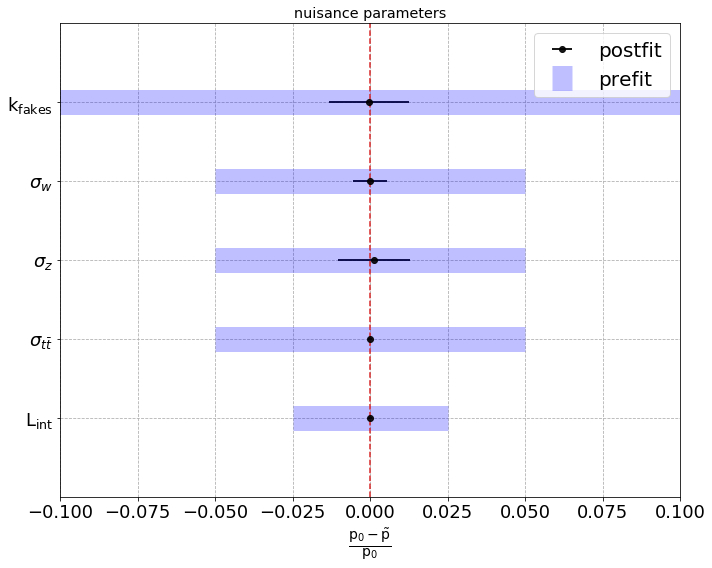

In [11]:
# 
fig = plt.figure(figsize=(10, 8), facecolor='white')
ax = plt.subplot()

nuisance_params = bias.transpose()[4:]
mean, stderr = nuisance_params.mean(axis=1), nuisance_params.std(axis=1)
iy = np.arange(nuisance_params.shape[0])
ax.errorbar(mean, iy+1, xerr = stderr, 
            fmt = 'ko',
            ecolor = 'k',
            capsize = 0.,
            elinewidth = 2.,
            alpha = 0.9
           )

err0 = np.array([0.025, 0.05, 0.05, 0.05, 0.5])#, 0.01, 0.01, 0.05]) 
ax.errorbar(np.zeros(mean.size), iy+1, xerr = err0, 
            fmt = 'none',
            ecolor = 'b',
            capsize = 0.,
            elinewidth = 25.,
            alpha = 0.25
           )

p_labels = [r'$\sf L_{int}$', r'$\sigma_{t\bar{t}}$',  r'$\sigma_{z}$',  r'$\sigma_{w}$', r'$\sf k_{fakes}$']#, r'$\sf \epsilon_{e}$', r'$\sf \epsilon_{\mu}$', r'$\sf \epsilon_{\tau}$']
ax.set_yticks(iy+1)
ax.set_yticklabels(p_labels)

ax.set_xlim(-0.1, 0.1)
ax.set_ylim(0., iy[-1]+2)
ax.set_xlabel(r'$\sf \frac{p_{0} - \tilde{p}}{p_{0}}$')
ax.set_title('nuisance parameters')
ax.legend(['postfit', 'prefit'])

plt.plot([0, 0], [0, iy[-1]+2], c='C3', linestyle='--')
plt.tight_layout()
plt.grid(linestyle='--')
plt.savefig(f'plots/systematics/nuisance_parameters_bias_{n_samples}.pdf')
plt.show()

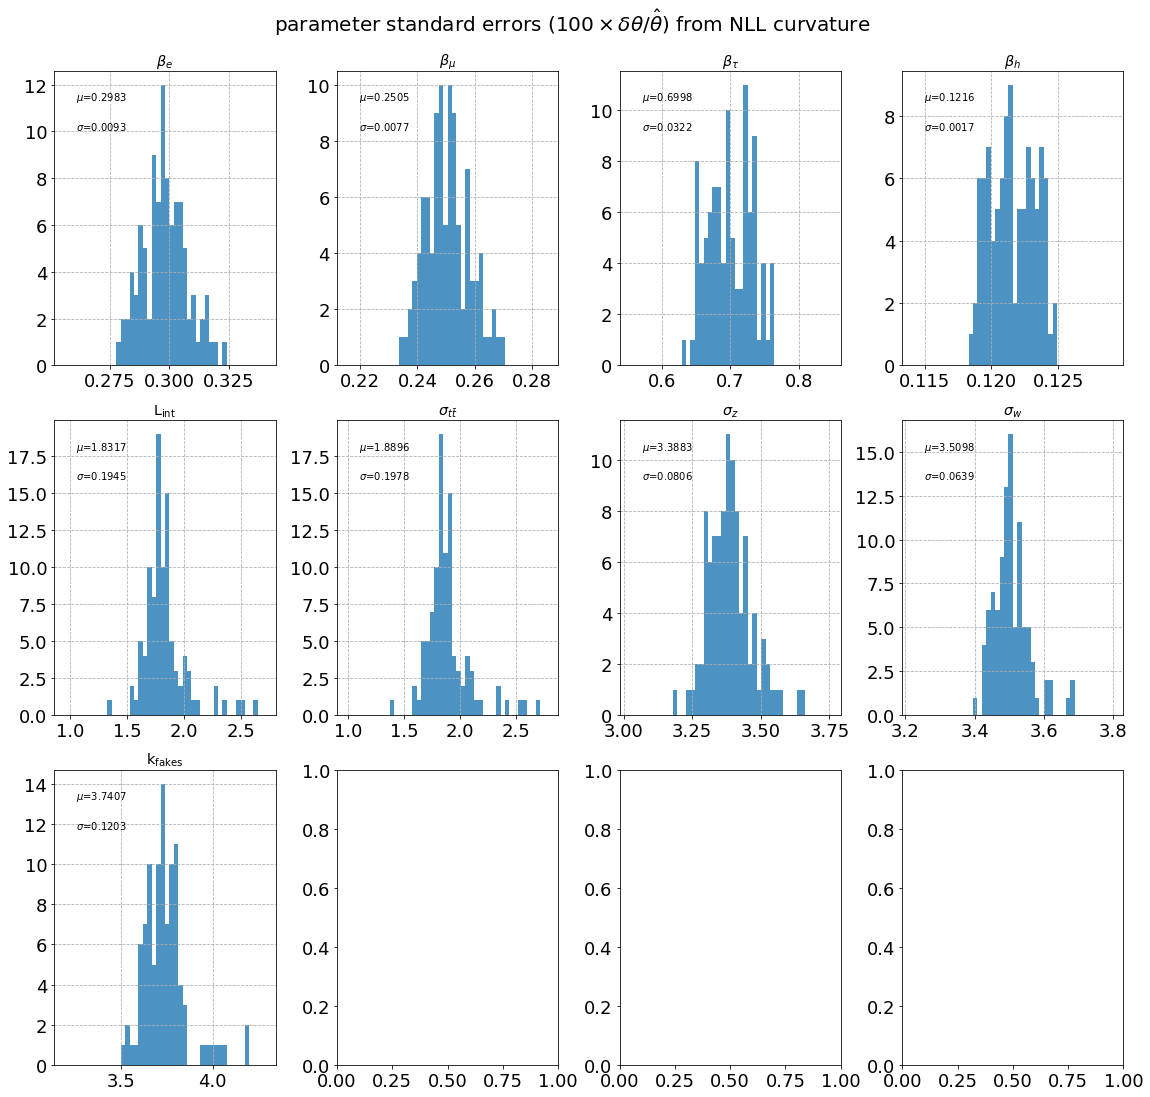

In [12]:
# variances
fig, axes = plt.subplots(3, 4, figsize=(16, 16), facecolor='white')

p_labels_full = [r'$\beta_{e}$', r'$\beta_{\mu}$', r'$\beta_{\tau}$', r'$\beta_{h}$'] + p_labels
variances = np.array([c[0] for c in cov]).transpose()
for i, v in enumerate(variances):
    ix, iy = int(i/4), int(i%4)
    ax = axes[ix][iy]
    mask = ~np.isnan(v)
    v = 100*v[mask]/results[:,i]
    mean, stderr = v.mean(), v.std()
    xmin, xmax = mean-5*stderr, mean+5*stderr
    ax.hist(v, bins=50, range=(xmin, xmax), histtype='stepfilled', alpha=0.8)
    ax.text(0.1, 0.9, r'$\mu$={0:.4f}'.format(mean), transform=ax.transAxes)
    ax.text(0.1, 0.8, r'$\sigma$={0:.4f}'.format(stderr), transform=ax.transAxes)

    ax.set_xlim(xmin, xmax)
    ax.set_title(p_labels_full[i])
    #ax.set_xlabel(r'$\sigma_{p}$')
    #ax.set_ylabel('Entries')
    ax.grid(linestyle='--')

#axes[-1][1].axis('off')
#axes[-1][2].axis('off')
#axes[-1][3].axis('off')

plt.suptitle(r'parameter standard errors ($100\times \delta\theta/\hat{\theta}$) from NLL curvature', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'plots/systematics/parameter_var_{n_samples}.pdf')
plt.show()